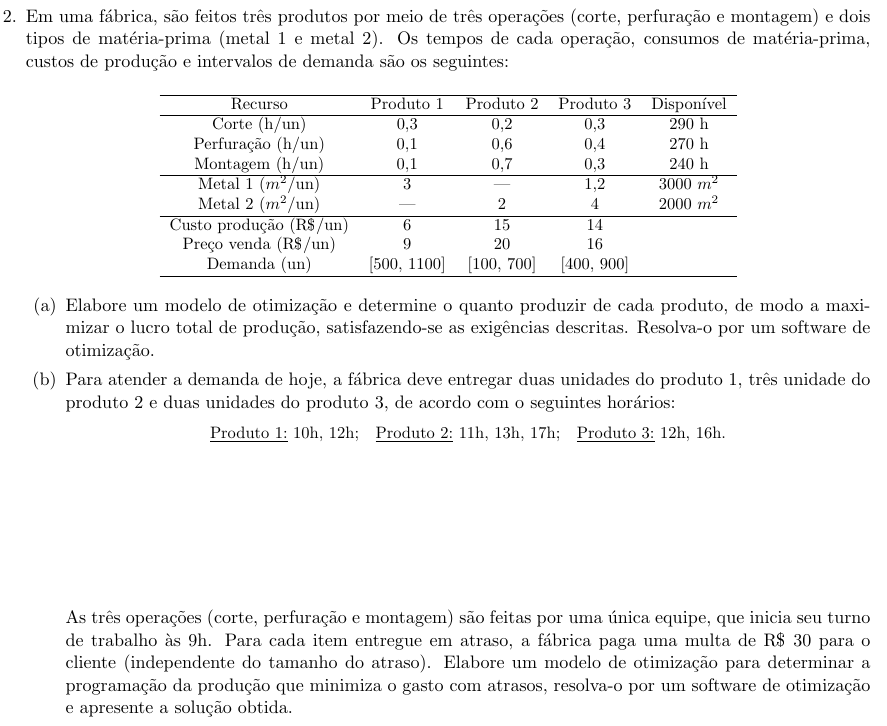

In [8]:
from IPython.display import Image
Image(filename='images/2.png')

In [2]:
# Módulos
from pyomo.environ import *
from pyomo.opt import SolverFactory

In [3]:
# Dados
Produtos = [1, 2, 3]
Recursos = ['Corte', 'Perfuração', 'Montagem', 'Metal 1', 'Metal 2']
qtd_R_P = {('Corte', 1): 0.3, ('Corte', 2): 0.2, ('Corte', 3): 0.3, 
           ('Perfuração', 1): 0.1, ('Perfuração', 2): 0.6, ('Perfuração', 3): 0.4,
           ('Montagem', 1): 0.1, ('Montagem', 2): 0.7, ('Montagem', 3): 0.3,
           ('Metal 1', 1): 3, ('Metal 1', 2): 0, ('Metal 1', 3): 1.2,
           ('Metal 2', 1): 0, ('Metal 2', 2): 2, ('Metal 2', 3): 4,}
preco_P = {1: 9, 2: 20, 3: 16}
custo_P = {1: 6, 2: 15, 3: 14}
disponibilidade_R = {'Corte': 290, 'Perfuração': 270, 'Montagem': 240, 
                     'Metal 1': 3000, 'Metal 2': 2000}
demanda_min_P = {1: 500, 2: 100, 3: 400}
demanda_max_P = {1: 1100, 2: 700, 3: 900}

In [4]:
# Modelo
model = ConcreteModel()

# Conjuntos
model.P = Set(initialize=Produtos)
model.R = Set(initialize=Recursos)
P, R = model.P, model.R

# Parâmetros
model.q = Param(R * P, initialize=qtd_R_P, within=NonNegativeReals)
model.p = Param(P, initialize=preco_P, within=NonNegativeReals)
model.c = Param(P, initialize=custo_P, within=NonNegativeReals)
model.a = Param(R, initialize=disponibilidade_R, within=NonNegativeReals)
model.L = Param(P, initialize=demanda_min_P, within=NonNegativeReals)
model.U = Param(P, initialize=demanda_max_P, within=NonNegativeReals)
q, p, c, a, L, U = model.q, model.p, model.c, model.a, model.L, model.U

# Variáveis de decisão
model.x = Var(P, within=NonNegativeIntegers)
x = model.x

# Função objetivo
model.obj = Objective(sense=maximize,
                      expr = sum((p[i] - c[i]) * x[i] for i in P))

# Restrições
# Disponibilidade
model.r_disp = ConstraintList()
for j in R:
    model.r_disp.add(expr = sum(q[j, i] * x[i] for i in P) <= a[j])
# Demanda
model.r_demanda = ConstraintList()
for i in P:
    model.r_demanda.add(expr = x[i] >= L[i])
    model.r_demanda.add(expr = x[i] <= U[i])
    
# model.pprint()

In [5]:
# Resolução
solver = SolverFactory('glpk')
resultado = solver.solve(model, tee=False)

In [6]:
# Apresentação de resultados
if (resultado.solver.status == SolverStatus.ok) and (resultado.solver.termination_condition != TerminationCondition.infeasible):
    for i in P:
        print('Devem ser produzidas {:.0f} unidades de {}.'.format(value(x[i]), i))
    print()
    print('O lucro máximo é de R${:.2f}.'.format(value(model.obj)))
else:
    print(resultado.solver.termination_condition)

Devem ser produzidas 500 unidades de 1.
Devem ser produzidas 100 unidades de 2.
Devem ser produzidas 400 unidades de 3.

O lucro máximo é de R$2800.00.


In [7]:
for j in R:
    print('Quantidade do recurso {} utilizado: {}'.format(j, value(sum(q[j, i] * x[i] for i in P))))

Quantidade do recurso Corte utilizado: 290.0
Quantidade do recurso Perfuração utilizado: 270.0
Quantidade do recurso Montagem utilizado: 240.0
Quantidade do recurso Metal 1 utilizado: 1980.0
Quantidade do recurso Metal 2 utilizado: 1800.0
